In [4]:
import numpy as np

In [5]:
# drive conditions that produce the maximum amplitude signal
BIAS = 0.82
UNITY_AMPLITUDE = 0.1
FRAME_LENGTH = 0.0055
FRAME_RATE = 179
DAC_RATE = 735294

In [16]:
def random_phase_multisine(N, P=1, gain=1, fs=1, process=None):
    '''
        N: number of samples in one signal period

        P: number of time domain periods to generate

        With a normalized amplitude spectrum, the DFT coefficient magnitudes U(k*fs/N) are scaled by 1/sqrt(N)
        U(k*fs/N) are uniformley bounded with a finite number of discontinuities on [0, fs/2].
        Further, the clock frequency fs is independent of N.

        Phase mean drawn from the random process must = 0
    '''

    if process is None:
        process = np.random.default_rng(123)

    #k = process.random(N - 1)
    k = process.integers(low=1, high=N, size=N-1)
    U = np.zeros(N * 2, dtype=np.complex128)

    # signal is real, so its spectrum is hermitian (negative frequencies are conjugate symmetric)
    samples = gain * np.exp(1j * 2 * np.pi * k / N)
    # create oscillator bank with dc value U[0] = 0
    U[1:N] = samples

    # create time domain signal
    u = 2 * np.sqrt(UNITY_AMPLITUDE) * np.real(np.fft.irfft(U))
    return u, U[:N]


In [17]:
def write_to_c_array(data):
    tablefile = open("table.c", "w")
    tablefile.write("#include <stdint.h>\n\n")
    tablefile.write("uint16_t drive_lut[] = { \\")
    for index, val in enumerate(data):
        if index % 32:
            tablefile.write(f'{int(val)},')
        else:
            tablefile.write(f'\n{int(val)},')
    tablefile.close()

4094


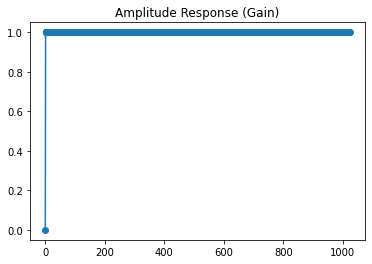

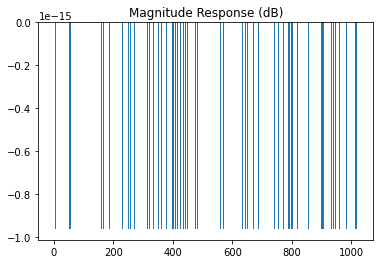

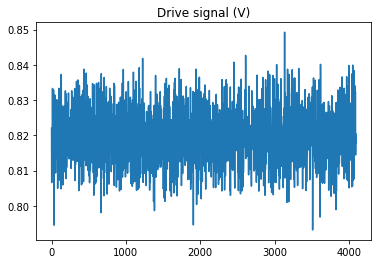

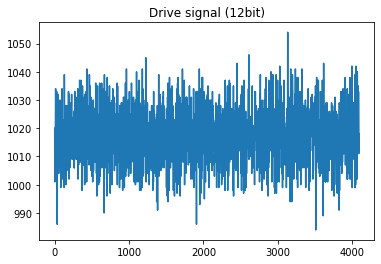

In [21]:
    import matplotlib.pyplot as plt
    N = 1024
    u, U = random_phase_multisine(N=N)

    plt.figure()
    plt.title('Amplitude Response (Gain)')
    plt.plot(np.abs(U), marker='o')

    #plt.figure()
    #plt.title('Test Response (Gain)')
    #checkfft = np.fft.rfft(u, n=len(u))[:N]
    #plt.plot(np.abs(checkfft), marker='o')

    plt.figure()
    plt.title('Magnitude Response (dB)')
    mag = 20 * np.log10(np.abs(U[1:]))
    plt.bar(np.arange(len(mag)), mag)

    # transform to be output ready
    u_out = u.copy()
    u_out += BIAS

    print(len(u_out))
    dac_table = np.round(u_out * 4095 / 3.3)
    write_to_c_array(dac_table)
    plt.figure()
    plt.title('Drive signal (V)')
    plt.plot(u_out)
    plt.figure()
    plt.title('Drive signal (12bit)')
    plt.plot(dac_table)
